In [2]:
%run setting.ipynb

# read property price data

https://fred.stlouisfed.org/series/CASTHPI

In [6]:
hpi_po_monthly_hist = pd.read_excel('CASTHPI.xls')

for c in hpi_po_monthly_hist:
    hpi_po_monthly_hist = hpi_po_monthly_hist.rename(columns={c: re.sub(r'[^A-z]+', '_', c.strip())})

In [7]:
hpi_po_monthly_hist

observation_date  CASTHPI
0         1975-01-01    41.69
1         1975-04-01    42.77
2         1975-07-01    44.36
3         1975-10-01    45.79
4         1976-01-01    47.82
..               ...      ...
192       2023-01-01   891.14
193       2023-04-01   913.78
194       2023-07-01   927.98
195       2023-10-01   930.34
196       2024-01-01   942.55

[197 rows x 2 columns]

In [9]:
hpi_po_monthly_hist.to_sql(
name='hpi_po_monthly_hist', 
con = conn,
if_exists='replace', 
index=False,
)

197

In [10]:
hpi_po_monthly_hist.columns

Index(['observation_date', 'CASTHPI'], dtype='object')

# compare to 30 years ago

In [11]:
leverage_rate = 5
holding_year = 30
price_column = 'CASTHPI'
date_column = 'observation_date'

result = sql(f"""
select 
a.{date_column} as current_month,
b.{date_column} as month_{holding_year}_years_ago,
cast(a.{price_column} as real) as current_property_price,
cast(b.{price_column} as real) as property_price_{holding_year}_years_ago
--
from hpi_po_monthly_hist as a 
left join hpi_po_monthly_hist as b
on DATE(a.{date_column}, '-{holding_year} years') = DATE(b.{date_column})
where DATE(b.{date_column}) is not null
and DATE(a.{date_column}) is not null
""")

In [12]:
result.head(3)

current_month   month_30_years_ago  current_property_price  \
0  2005-01-01 00:00:00  1975-01-01 00:00:00                  538.76   
1  2005-04-01 00:00:00  1975-04-01 00:00:00                  570.36   
2  2005-07-01 00:00:00  1975-07-01 00:00:00                  598.83   

   property_price_30_years_ago  
0                        41.69  
1                        42.77  
2                        44.36

# attached the nasdaq 100 price

In [16]:
import yfinance as yf
import pandas as pd

# Load QQQ ETF data
qqq = yf.Ticker("^NDX")

# Get historical data
data = qqq.history(period="max")

def get_median_close_price(date_str):
    
    try:
        # Parse the input date to extract the year and month
        date = pd.to_datetime(date_str)
        year_month = date.strftime('%Y-%m')  # Format 'YYYY-MM'

        # Filter the data for the specific month
        monthly_data = data.loc[year_month]

        # Calculate the median of the 'Close' prices
        median_close_price = monthly_data['Close'].median()

        return median_close_price
    except:
        return None

In [17]:
result['current_nq100_price'] = result['current_month'].apply(get_median_close_price)
result[f'nq100_price_{holding_year}_years_ago'] = result[f'month_{holding_year}_years_ago'].apply(get_median_close_price)

In [18]:
result.to_sql(
name='monthly_price', 
con = conn,
if_exists='replace', 
index=False,
)

77

In [20]:
result.head(3)

current_month   month_30_years_ago  current_property_price  \
0  2005-01-01 00:00:00  1975-01-01 00:00:00                  538.76   
1  2005-04-01 00:00:00  1975-04-01 00:00:00                  570.36   
2  2005-07-01 00:00:00  1975-07-01 00:00:00                  598.83   

   property_price_30_years_ago  current_nq100_price  nq100_price_30_years_ago  
0                        41.69          1549.525024                       NaN  
1                        42.77          1441.130005                       NaN  
2                        44.36          1575.629944                       NaN

# calculate the return

In [24]:
return_date = sql(f"""
select *,
current_nq100_price/nq100_price_{holding_year}_years_ago -1 as nq100_return,
current_property_price/property_price_{holding_year}_years_ago - 1 as property_return,
current_property_price/property_price_{holding_year}_years_ago*{leverage_rate} - 1 as property_x_{leverage_rate}_leverage_return
from monthly_price
where nq100_return is not null
""")

In [25]:
return_date.head(3)

current_month   month_30_years_ago  current_property_price  \
0  2015-10-01 00:00:00  1985-10-01 00:00:00                  537.40   
1  2016-01-01 00:00:00  1986-01-01 00:00:00                  544.44   
2  2016-04-01 00:00:00  1986-04-01 00:00:00                  554.09   

   property_price_30_years_ago  current_nq100_price  nq100_price_30_years_ago  \
0                       130.55          4415.870117                113.680000   
1                       132.24          4259.770020                131.125000   
2                       134.78          4496.040039                154.915001   

   nq100_return  property_return  property_x_5_leverage_return  
0     37.844741          3.11643                     19.582152  
1     31.486330          3.11706                     19.585299  
2     28.022625          3.11107                     19.555349

# plot the return 

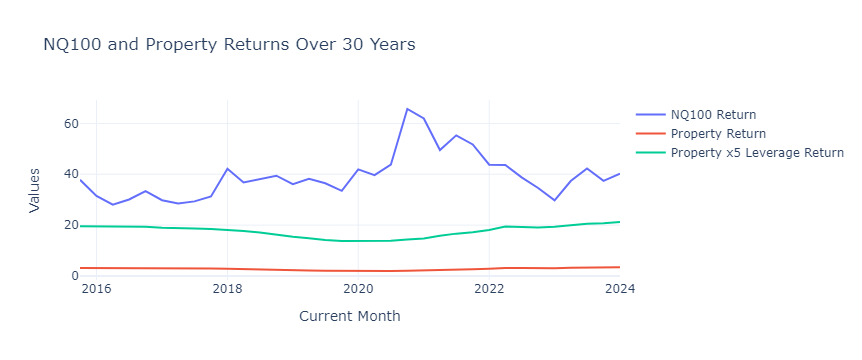

In [26]:
import pandas as pd
import plotly.graph_objects as go

def plot_data(df):
    # Create a Plotly figure
    fig = go.Figure()

    # Plot nq100_return
    fig.add_trace(go.Scatter(x=df['current_month'],
                             y=df['nq100_return'],
                             mode='lines',
                             name='NQ100 Return'))

    # Plot property_return
    fig.add_trace(go.Scatter(x=df['current_month'],
                             y=df['property_return'],
                             mode='lines',
                             name='Property Return'))

    # Plot property_x_5_leverage_return
    fig.add_trace(go.Scatter(x=df['current_month'],
                             y=df['property_x_5_leverage_return'],
                             mode='lines',
                             name='Property x5 Leverage Return'))

    # Update layout
    fig.update_layout(title=f'NQ100 and Property Returns Over {holding_year} Years',
                      xaxis_title='Current Month',
                      yaxis_title='Values',
                      template='plotly_white')

    # Show the plot
    fig.show()

# Call the function to plot the data
plot_data(return_date)

# show the return median

In [27]:
return_date[[
'nq100_return',
'property_return',
f'property_x_{leverage_rate}_leverage_return'
]].median()

nq100_return                    38.023419
property_return                  2.851894
property_x_5_leverage_return    18.259470
dtype: float64

# show the return average

In [28]:
return_date[[
'nq100_return',
'property_return',
f'property_x_{leverage_rate}_leverage_return'
]].mean()

nq100_return                    39.350083
property_return                  2.716241
property_x_5_leverage_return    17.581207
dtype: float64

# save the returns to excel 

In [30]:
return_date.to_excel(f'california_property_price_vs_nq100.xlsx', index = False)

# end